In [1]:
# Import everything needed to edit/save/watch video clips
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


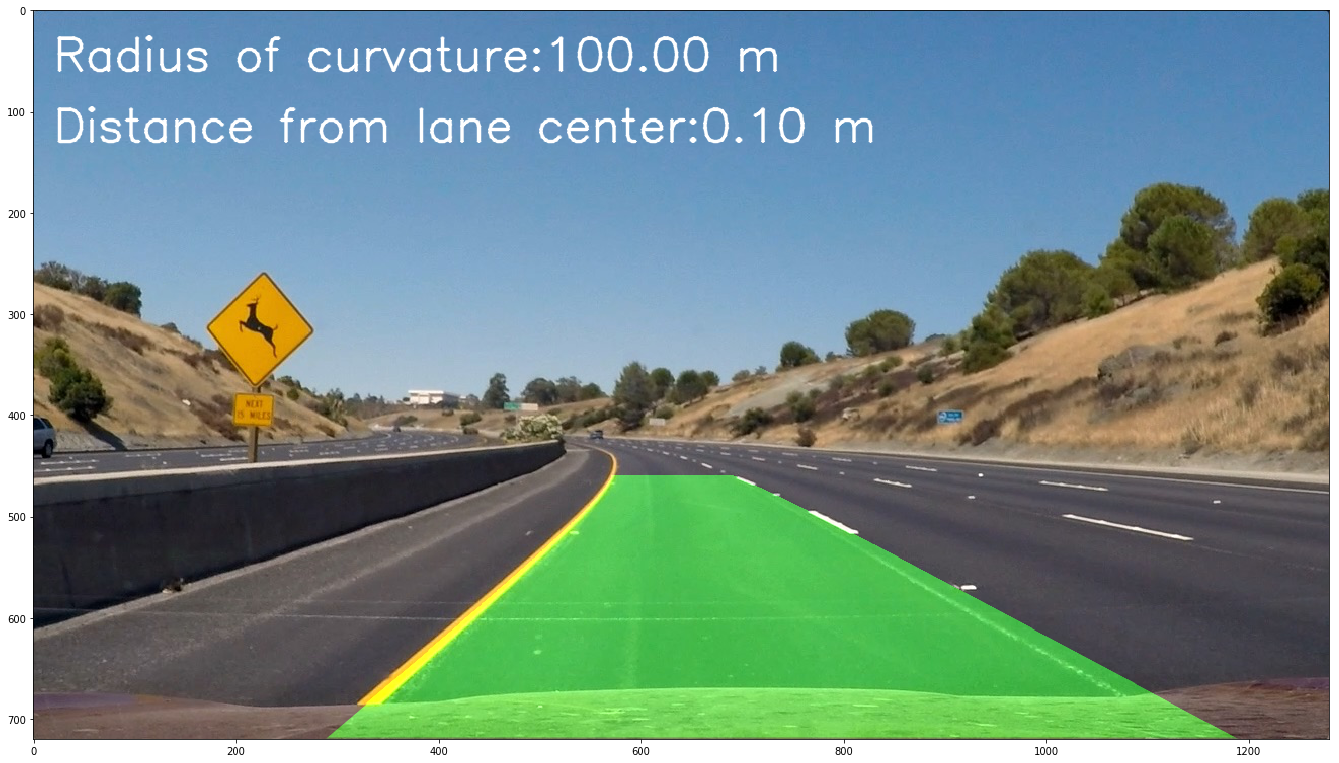

In [134]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.path import Path
import matplotlib.image as mpimg


def excludeValues(binary_image):
    sumval = binary_image.sum(axis=0)
    sumvalY = binary_image.sum(axis=1)
    
    left = sumval[:len(sumval)//2]
    right = sumval[len(sumval)//2:]

    maxLeft = max(left)
    maxRight = max(right)
    maxY = max(sumvalY)

    tresholdLeft = maxLeft - 50
    tresholdRight = maxRight - 50
    thresholdY = maxY / 2
    
    indexiesLeft = [index for index in range(len(left)) if left[index] > tresholdLeft]
    indexiesRight = [index for index in range(len(right)) if right[index] > tresholdRight]
    indexiesY = [index for index in range(len(sumvalY)) if sumvalY[index] > thresholdY]
    
    midpoint = binary_image.shape[1]//2
    
    indexiesRightTransformed = [x + midpoint for x in indexiesRight]
    
    indexies = np.concatenate((indexiesLeft,indexiesRightTransformed)) 
  
    minX = min(indexiesLeft)
    maxX = max(indexiesRight)
    minY = min(indexiesY)
    maxY = max(indexiesY)
    
    masked = np.concatenate(([[350,maxY], [50,minY]],[[780, minY], [780,maxY]]), axis=0)
    pts = np.array(masked, np.int32)
    cv2.fillConvexPoly(binary_image, pts,(0,0,0))
    
#     for y in range(binary_image.shape[0]):
#         if y not in indexiesY:
#             for x in range(binary_image.shape[1]):
#                 if x not in indexies:
#                     binary_image[sumvalY[y],x] = 0
    

         
    return binary_image


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    try:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    except ValueError:
        plt.imshow(binary_warped)

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    ym_per_p = 30/720 # meters per pixel in y dimension
    xm_per_p = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_p, leftx*xm_per_p, 2)   # for radius calculation
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_m = np.polyfit(righty*ym_per_p, rightx*xm_per_p, 2)  

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    #  plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, left_fit_m, right_fit, right_fit_m, out_img



def process_image(image):
    # STEP 2: Apply a distortion correction to raw images
    dstimg = cv2.undistort(image, mtx, dist, None, mtx)


    # STEP 3: Use color transforms, gradients, etc., to create a thresholded binary image

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(dstimg, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 150) & (s_channel <= 255)] = 1


    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1



    # STEP 4: Apply a perspective transform to rectify binary image 
    # source and destination points (top left, top right, bottom right, bottom left) for warping street to birds view 
    img_size = (image.shape[1], image.shape[0])


    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])  
    # use cv2.getPerspectiveTransform() to get M and Minv, the transform matrix and inverse transform matrices to warp the street to birds view and back
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    masked_left = np.concatenate(([[550,450], [0,400]],[[0, 700], [180,700]]), axis=0)
    ptsLeft = np.array(masked_left, np.int32)
    cv2.fillConvexPoly(combined_binary, ptsLeft,(0,0,0))
    
    
    masked_right = np.concatenate(([[750,450],[1280,400]],[[1280, 700], [1180,700]]), axis=0)
    ptsRight = np.array(masked_right, np.int32)
    cv2.fillConvexPoly(combined_binary, ptsRight,(0,0,0))
    
    masked_center = np.concatenate(([[650,440], [650,440]],[[1080,720],[320,720]]), axis=0)
    pts = np.array(masked_center, np.int32)
    cv2.fillConvexPoly(combined_binary, pts,(0,0,0))

    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    
#     test = excludeValues(binary_warped)

    # STEP 5 - Detect lane pixels and fit to find the lane boundary
    # left_fit_p, right_fit_p, left_curverad, right_curverad, left_fit_m, right_fit_m = fit_polynomial(binary_warped)

    # plt.subplots_adjust(left=0., right=3, top=5.9, bottom=2.)
    # plt.imshow(binary_warped, cmap="gray")

    left_fit_p, left_fit_m, right_fit_p, right_fit_m, out_img = fit_polynomial(binary_warped)
    
    # Create an image to draw the lines on
    rows, cols = binary_warped.shape[:2]
    warp_zero = np.zeros(out_img.shape[:2], dtype=np.uint8)
    lane_image = np.dstack((warp_zero, warp_zero, warp_zero))

    # generate the plot points
    plot_y = np.linspace(0, rows-1, rows) # return evenly spaced numbers over a specified interval.
    left_fit_x = np.polyval(left_fit_p, plot_y)  # calculate the points for the left lane 
    right_fit_x = np.polyval(right_fit_p, plot_y) # calculate the points for the right lane 

    # Put left and right points together
    leftPoints2Lists = np.vstack([left_fit_x, plot_y])
    rigthPoints2Lists = np.vstack([right_fit_x, plot_y])

    # make array with [x,y],[x,y],... 
    leftPoints = np.transpose(leftPoints2Lists)
    rightPoints = np.flipud(np.transpose(rigthPoints2Lists))

    # lets put the points in yet another array 
    leftPointsArray = np.array([leftPoints])
    rightPointsArray = np.array([rightPoints])

    # stack arrays in sequence horizontally (column wise).
    polygon_pts = np.hstack((leftPointsArray, rightPointsArray))

    # draw the polygon/lane onto the warped blank image
    cv2.fillPoly(lane_image, np.int_([polygon_pts]), (0,240, 0))

    test = np.dstack((combined_binary, combined_binary, combined_binary))*255

#     masked_left = np.concatenate(([[550,450], [0,400]],[[0, 700], [180,700]]), axis=0)
#     ptsLeft = np.array(masked_left, np.int32)
#     cv2.fillConvexPoly(test, ptsLeft,(0,0,0))
    
    
#     masked_right = np.concatenate(([[750,450],[1280,400]],[[1280, 700], [1180,700]]), axis=0)
#     ptsRight = np.array(masked_right, np.int32)
#     cv2.fillConvexPoly(test, ptsRight,(0,0,0))
    
#     masked_center = np.concatenate(([[650,440], [650,440]],[[1080,720],[320,720]]), axis=0)
#     pts = np.array(masked_center, np.int32)
#     cv2.fillConvexPoly(test, pts,(255,0,0))

    lane_image_warped = cv2.warpPerspective(lane_image, Minv, out_img.shape[1::-1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Radius of curvature:{0:>4.2f} m'.format(100), (20,60), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(image, 'Distance from lane center:{0:>4.2f} m'.format(0.1), (20,130), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    
#     cv2.addWeighted(lane_image_warped, 0.5, image, 1, 0)
    return cv2.addWeighted(lane_image_warped, 0.5, image, 1, 0)

fname = 'test_images/test2.jpg'
image = mpimg.imread(fname)
# converted = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
img = process_image(image)
plt.subplots_adjust(left=0., right=3, top=5.9, bottom=2.)
plt.imshow(img)

# white_output = 'test_videos_output/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
  
</video>
""".format(white_output))

In [5]:
arr = np.array([np.array([22,33,0, 34,3]),np.array([123,0,100,25,4]),np.array([0,0,0,45,5])])

In [424]:
sumval = arr.sum(axis=1)

In [425]:
print(sumval)

[ 92 252  50]


In [323]:
left = sumval[:len(sumval)//2]
right = sumval[len(sumval)//2:]

maxLeft = max(left)
maxRight = max(right)

tresholdLeft = maxLeft - 30
tresholdRight = maxRight - 30

print(tresholdLeft)
print(tresholdRight)
        

115
74


In [324]:
indexiesLeft = [index for index in range(len(left)) if left[index] > tresholdLeft]

indexiesRight = [index for index in range(len(right)) if right[index] > tresholdRight]

In [358]:
print(arr)


[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [359]:
arr[:,3] = 0
print(midpoint)

1


In [371]:
midpoint = arr.shape[1]//2
print(midpoint)

2


In [372]:
indexiesRightTransformed = [x + midpoint for x in indexiesRight]

In [377]:
 indexies = np.concatenate((indexiesLeft,indexiesRightTransformed)) 

In [378]:
print(indexies)

[0 2 3]


In [427]:
for i in range(arr.shape[1]):
    if i not in indexies:
        arr[0,i] = 0

In [428]:
print(arr)

[[ 22   0   0  34   0]
 [123   0 100  25   4]
 [  0   0   0  45   5]]


In [396]:
def excludeValues(binary_image):
    sumval = binary_image.sum(axis=0)
    
    left = sumval[:len(sumval)//2]
    right = sumval[len(sumval)//2:]

    maxLeft = max(left)
    maxRight = max(right)

    tresholdLeft = maxLeft - 50
    tresholdRight = maxRight - 50
    
    
    indexiesLeft = [index for index in range(len(left)) if left[index] > tresholdLeft]
    indexiesRight = [index for index in range(len(right)) if right[index] > tresholdRight]
    
    midpoint = binary_image.shape[1]//2
    
    indexiesRightTransformed = [x + midpoint for x in indexiesRight]
    
    indexies = np.concatenate((indexiesLeft,indexiesRightTransformed)) 
    
    for i in range(binary_image.shape[1]):
        if i not in indexies:
            binary_image[:,i] = 0
            
    return binary_image
    

In [393]:
print(binary_warped)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [397]:
itog = exclude(binary_warped)

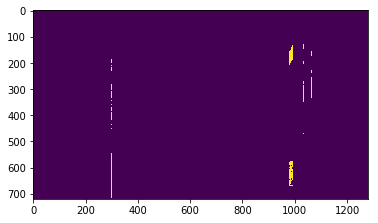

In [398]:
plt.imshow(itog)

In [14]:
print()

22
